In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
import shutil

if os.path.exists("/content/Train_Data"):
  shutil.rmtree("/content/Train_Data")
if os.path.exists("/content/Val_data"):
  shutil.rmtree("/content/Val_data")

shutil.copytree("/content/drive/MyDrive/covid-19/covid-19/covid-19/TrainData/COVID-19", "/content/Train_Data")

data_dir = "/content/Train_Data"

shutil.copytree("/content/drive/MyDrive/covid-19/covid-19/covid-19/Val_data", "/content/Val_data")

Val_dir = "/content/Val_data"

In [ ]:
if os.path.exists("/content/test_data"):
  shutil.rmtree("/content/test_data")

shutil.copytree("/content/drive/MyDrive/covid-19/covid-19/covid-19/testdata/COVID-19", "/content/test_data")

'/content/test_data'

In [ ]:
import os
import shutil

# Paths
normal_path = "/content/Train_Data/NORMAL"
no_covid_path = "/content/Train_Data/no_covid"

# Create NORMAL directory if it doesn't exist
os.makedirs(normal_path, exist_ok=True)

# Move all files from no_covid to NORMAL
for filename in os.listdir(no_covid_path):
    src = os.path.join(no_covid_path, filename)
    dst = os.path.join(normal_path, filename)
    if os.path.isfile(src):
        shutil.move(src, dst)

# Optionally, remove the empty no_covid directory
shutil.rmtree(no_covid_path)

print("Successfully merged no_covid into NORMAL.")

Successfully merged no_covid into NORMAL.


In [ ]:
import os
import shutil

# Paths
normal_path = "/content/Val_data/NORMAL"
no_covid_path = "/content/Val_data/no_covid"

# Create NORMAL directory if it doesn't exist
os.makedirs(normal_path, exist_ok=True)

# Move all files from no_covid to NORMAL
for filename in os.listdir(no_covid_path):
    src = os.path.join(no_covid_path, filename)
    dst = os.path.join(normal_path, filename)
    if os.path.isfile(src):
        shutil.move(src, dst)

# Optionally, remove the empty no_covid directory
shutil.rmtree(no_covid_path)

print("Successfully merged no_covid into NORMAL.")

Successfully merged no_covid into NORMAL.


In [ ]:
import os
import shutil

# Paths
normal_path = "/content/test_data/NORMAL"
no_covid_path = "/content/test_data/no_covid"

# Create NORMAL directory if it doesn't exist
os.makedirs(normal_path, exist_ok=True)

# Move all files from no_covid to NORMAL
for filename in os.listdir(no_covid_path):
    src = os.path.join(no_covid_path, filename)
    dst = os.path.join(normal_path, filename)
    if os.path.isfile(src):
        shutil.move(src, dst)

# Optionally, remove the empty no_covid directory
shutil.rmtree(no_covid_path)

print("Successfully merged no_covid into NORMAL.")

Successfully merged no_covid into NORMAL.


In [ ]:
import os
print("Train samples:", len(os.listdir(data_dir)))
print("Val samples:", len(os.listdir(Val_dir)))
print("Val samples:", len(os.listdir('/content/test_data')))

Train samples: 8
Val samples: 8
Val samples: 8


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

True


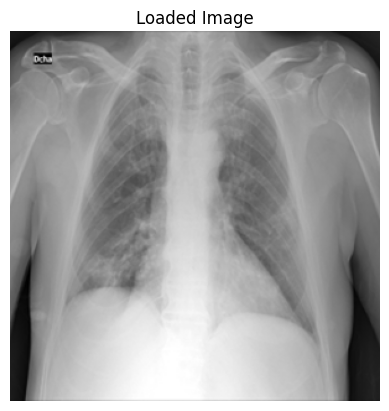

In [ ]:
image_path = "/content/drive/MyDrive/covid-19/covid-19/covid-19/TrainData/COVID-19/COVID/COVID-12.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

print(os.path.exists(image_path))
#print(os.listdir('/content/drive/MyDrive/covid-19/covid-19/TrainData/COVID-19/COVID/_0_1465610.jpeg'))

if image is not None:
    plt.imshow(image, cmap='gray')
    plt.title("Loaded Image")
    plt.axis('off')
    plt.show()
else:
    print("Error: Could not load image.")

In [ ]:
image.shape

(299, 299)

Found 6373 images belonging to 8 classes.
Found 900 images belonging to 8 classes.


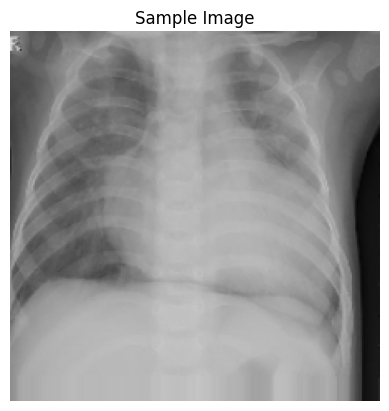

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision, layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import gc
import matplotlib.pyplot as plt

# Enable mixed precision for reduced memory usage
mixed_precision.set_global_policy('float32')

# Define paths
data_dir = "/content/Train_Data"
Val_dir =  "/content/Val_data"
# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data Generator for efficient data loading
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.95, 1.05],
    fill_mode='nearest'
)


train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed = 42
)

train_data.num_workers = 8

val_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    Val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


# Clean up unused variables
del data_dir
gc.collect()

# Display a sample image
sample_image, sample_label = next(train_data)
plt.imshow(sample_image[0])
plt.title("Sample Image")
plt.axis('off')
plt.show()

In [ ]:
print(train_data.class_indices)

{'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'basal_cell_carcinoma': 3, 'glioma_tumor': 4, 'melanoma': 5, 'no_tumor': 6, 'pituitary_tumor': 7}


In [ ]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.exp(-ce)
        return alpha * tf.pow(1. - pt, gamma) * ce
    return loss

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# Load VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-8:]:
    layer.trainable = True

# Custom Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=focal_loss(),
              metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,983,496 (57.16 MB)

 Trainable params: 13,246,984 (50.53 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights for balancing
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)))

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate when accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Model checkpoint for saving the best model
checkpoint_callback = ModelCheckpoint(
    "/content/drive/MyDrive/model_checkpoint.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Train the model with class weights and callbacks
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6790 - loss: 0.6212
Epoch 1: val_loss improved from inf to 0.49959, saving model to /content/drive/MyDrive/model_checkpoint.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 177s 816ms/step - accuracy: 0.6795 - loss: 0.6208 - val_accuracy: 0.7956 - val_loss: 0.4996 - learning_rate: 1.0000e-04
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8871 - loss: 0.4541
Epoch 2: val_loss improved from 0.49959 to 0.41019, saving model to /content/drive/MyDrive/model_checkpoint.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 706ms/step - accuracy: 0.8872 - loss: 0.4541 - val_accuracy: 0.8900 - val_loss: 0.4102 - learning_rate: 1.0000e-04
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9163 - loss: 0.3872
Epoch 3: val_loss improved from 0.41019 to 0.36791, saving model to /content/drive/MyDrive/model_checkpoint.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 137s 686ms/step - accuracy: 0.9163 - loss: 0.3872 - val_accuracy: 0.851

In [ ]:
model.save('/content/drive/MyDrive/DISEASE_DETECTION_MODEL.keras')
print("Model saved to Google Drive successfully")

Model saved to Google Drive successfully


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load model directly without loading weights separately
model = load_model('/content/drive/MyDrive/MULTI_DISEASE_DETECTION_MODEL.keras')

# Ensure correct data preprocessing (rescale only)
test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/test_data',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    classes=train_data.class_indices
)

# Evaluate model
model.evaluate(test_data)

Found 1672 images belonging to 8 classes.
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 0.9071 - loss: 0.7615


[1.19121253490448, 0.8349282145500183]

In [ ]:
print("Test class indices:", test_data.class_indices)

Test class indices: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'basal_cell_carcinoma': 3, 'glioma_tumor': 4, 'melanoma': 5, 'no_tumor': 6, 'pituitary_tumor': 7}


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

print(classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys())))

105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step
                      precision    recall  f1-score   support

               COVID       0.99      0.96      0.97       250
              NORMAL       1.00      0.80      0.89       684
           PNEUMONIA       0.72      1.00      0.84       390
basal_cell_carcinoma       0.76      0.93      0.84        30
        glioma_tumor       0.83      0.24      0.37       100
            melanoma       0.94      0.77      0.85        39
            no_tumor       0.50      0.98      0.66       105
     pituitary_tumor       0.86      0.49      0.62        74

            accuracy                           0.83      1672
           macro avg       0.82      0.77      0.75      1672
        weighted avg       0.88      0.83      0.83      1672



105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step


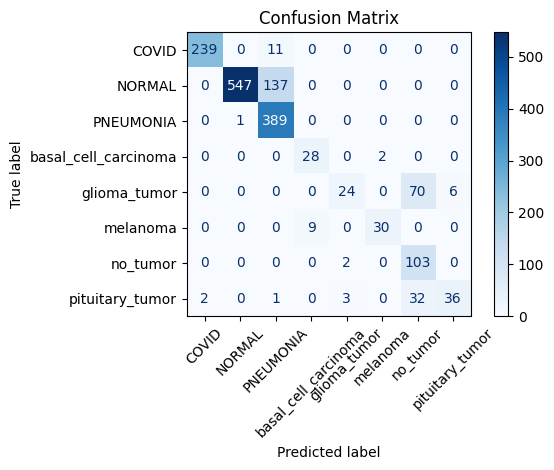

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# All class labels from the generator
class_labels = list(test_data.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(class_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/MULTI_DISEASE_DETECTION_MODEL.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model

Model = load_model('/content/drive/MyDrive/DISEASE_DETECTION_MODEL.keras')
print("Model loaded successfully.")

Model loaded successfully.


105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step


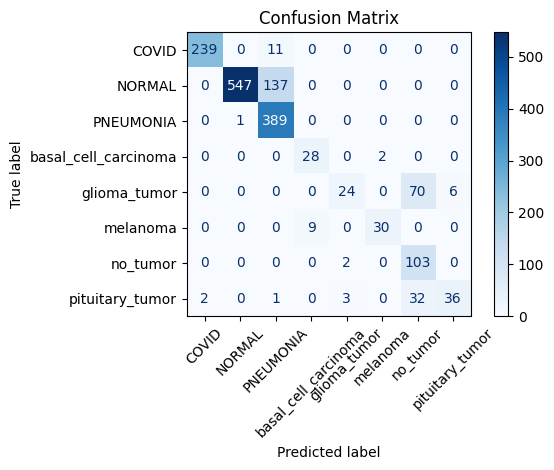

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_true = test_data.classes
y_pred_probs = Model.predict(test_data)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# All class labels from the generator
class_labels = list(test_data.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(class_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [5]:
import os
import shutil

# Clear existing directories
for folder in ["/content/Train_Data", "/content/Val_data"]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

# Source class folders
train_classes = ["glioma_tumor", "pituitary_tumor", "no_tumor"]
val_classes = ["glioma_tumor", "pituitary_tumor", "no_tumor"]

# Copy training data
for cls in train_classes:
    src = f"/content/drive/MyDrive/covid-19/covid-19/covid-19/TrainData/COVID-19/{cls}"
    dst = f"/content/Train_Data/{cls}"
    shutil.copytree(src, dst)

# Copy validation data
for cls in val_classes:
    src = f"/content/drive/MyDrive/covid-19/covid-19/covid-19/Val_data/{cls}"
    dst = f"/content/Val_data/{cls}"
    shutil.copytree(src, dst)

print("Data copied successfully.")


Data copied successfully.


In [6]:
import os
import shutil

# Clear existing test_data directory
test_dir = "/content/test_data"
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

# Correct class list
test_classes = ["glioma_tumor", "pituitary_tumor", "no_tumor"]

# Copy test data from Drive to local test directory
for cls in test_classes:
    src = f"/content/drive/MyDrive/covid-19/covid-19/covid-19/testdata/COVID-19/{cls}"
    dst = f"{test_dir}/{cls}"
    shutil.copytree(src, dst)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)  # Change if your model uses a different size

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)


train_generator = train_datagen.flow_from_directory(
    '/content/Train_Data',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '/content/Val_data',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1560 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy


# Set class weights (more weight to tumor classes)
class_weights = {0: 3.0, 1: 1.0, 2: 2.0}

# Model (VGG16 with additional layers)
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load VGG16 base model without the top layer (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes for glioma, pituitary, and no tumor
])

# Compile model with Weighted Categorical Crossentropy and Adam optimizer
loss_fn = CategoricalCrossentropy()

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=loss_fn,
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12,  # You can adjust the number of epochs as needed
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights
)



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,931 (57.15 MB)

 Trainable params: 265,219 (1.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

Epoch 1/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 702s 15s/step - accuracy: 0.4922 - loss: 2.3609 - val_accuracy: 0.4688 - val_loss: 1.0137
Epoch 2/12
 1/48 ━━━━━━━━━━━━━━━━━━━━ 9:29 12s/step - accuracy: 0.7812 - loss: 0.8710

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7812 - loss: 0.8710 - val_accuracy: 0.4653 - val_loss: 1.0144
Epoch 3/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 741s 15s/step - accuracy: 0.7739 - loss: 1.0603 - val_accuracy: 0.5903 - val_loss: 0.9392
Epoch 4/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7500 - loss: 1.0924 - val_accuracy: 0.5972 - val_loss: 0.9355
Epoch 5/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 744s 16s/step - accuracy: 0.8259 - loss: 0.8191 - val_accuracy: 0.6806 - val_loss: 0.8410
Epoch 6/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.7188 - loss: 1.1506 - val_accuracy: 0.6701 - val_loss: 0.8429
Epoch 7/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 742s 15s/step - accuracy: 0.8377 - loss: 0.7543 - val_accuracy: 0.7188 - val_loss: 0.7364
Epoch 8/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9062 - loss: 0.5716 - val_accuracy: 0.6979 - val_loss: 0.7479
Epoch 9/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 717s 15s/step - accuracy: 0.8733 - loss: 0.6379 - val_accuracy: 0.7569 - val_loss

In [24]:
model.save('/content/drive/MyDrive/TUMOR_DETECTION_Model.keras')

In [ ]:
print(f"Number of batches: {len(test_data)}")
print(f"Class indices: {test_data.class_indices}")

Number of batches: 18
Class indices: {'glioma_tumor': 0, 'no_tumor': 1, 'pituitary_tumor': 2}


In [ ]:
x_batch, y_batch = next(iter(test_data))
print("Input shape:", x_batch.shape)
print("Label shape:", y_batch.shape)
print("Predictions shape:", model.predict(x_batch).shape)


Input shape: (16, 224, 224, 3)
Label shape: (16, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predictions shape: (16, 3)


In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load model directly without loading weights separately
model = load_model('/content/drive/MyDrive/TUMOR_DETECTION_Model.keras')

# Ensure correct data preprocessing (rescale only)
test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/test_data',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    classes=train_generator.class_indices
)

# Evaluate model
model.evaluate(test_data)

Found 279 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 107s 6s/step - accuracy: 0.3947 - loss: 1.3233


[0.9954708218574524, 0.5555555820465088]

18/18 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step


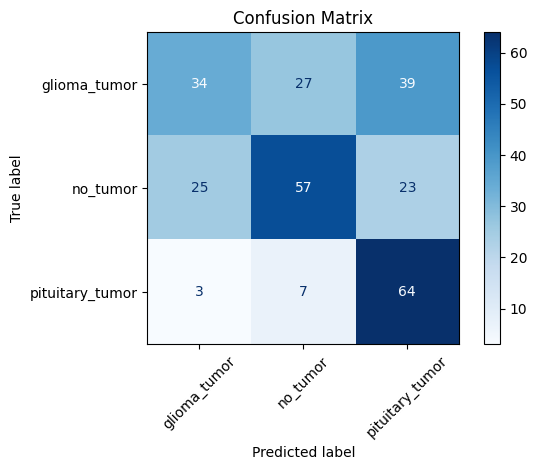

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/TUMOR_DETECTION_Model.keras')
# Predict
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# All class labels from the generator
class_labels = list(test_data.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(class_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Found 1560 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Class Weights: {0: np.float64(0.8), 1: np.float64(1.6774193548387097), 2: np.float64(0.8666666666666667)}


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,931 (57.15 MB)

 Trainable params: 7,344,643 (28.02 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4668 - loss: 1.0662
Epoch 1: val_loss improved from inf to 0.93609, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 896s 9s/step - accuracy: 0.4683 - loss: 1.0641 - val_accuracy: 0.6840 - val_loss: 0.9361 - learning_rate: 1.0000e-05
Epoch 2/20
 1/97 ━━━━━━━━━━━━━━━━━━━━ 12:51 8s/step - accuracy: 0.6875 - loss: 0.7833

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.93609 to 0.92937, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.6875 - loss: 0.7833 - val_accuracy: 0.7118 - val_loss: 0.9294 - learning_rate: 1.0000e-05
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8054 - loss: 0.4872
Epoch 3: val_loss improved from 0.92937 to 0.72590, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 864s 9s/step - accuracy: 0.8056 - loss: 0.4869 - val_accuracy: 0.7986 - val_loss: 0.7259 - learning_rate: 1.0000e-05
Epoch 4/20
 1/97 ━━━━━━━━━━━━━━━━━━━━ 11:32 7s/step - accuracy: 0.8750 - loss: 0.4939
Epoch 4: val_loss did not improve from 0.72590
97/97 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8750 - loss: 0.4939 - val_accuracy: 0.8021 - val_loss: 0.7375 - learning_rate: 1.0000e-05
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8856 - loss: 0.3471
Epoch 5: val_loss improved from 0.72590 to 0.51794, saving model to best_model.keras
97/97 ━━━━━━━

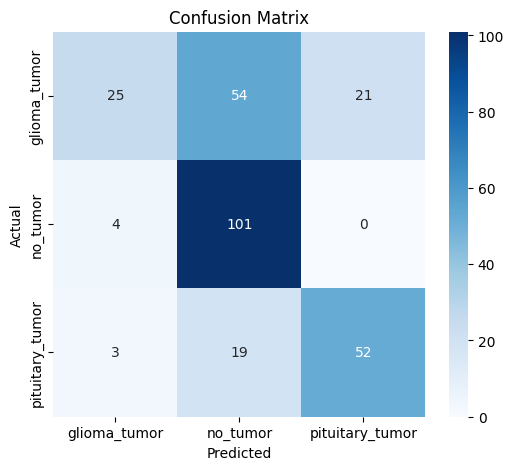

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ------------------ Data Augmentation ------------------
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

train_generator = train_aug.flow_from_directory(
    '/content/Train_Data',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

val_generator = train_aug.flow_from_directory(
    '/content/Val_data',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

# ------------------ Class Weights ------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# ------------------ Model ------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all but the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# ------------------ Compile ------------------
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

# ------------------ Callbacks ------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# ------------------ Train ------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights,
    callbacks=callbacks
)

# ------------------ Evaluation ------------------
test_aug = ImageDataGenerator(rescale=1./255)
test_generator = test_aug.flow_from_directory(
    '/content/test_data',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

loss, acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# ------------------ Classification Report ------------------
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [29]:
model.save('/content/drive/MyDrive/tumor_detection_model.keras')